# Walsh transformations

## Initializing

In [1]:
import scipy as sp
import pylab as pl
import cmath as cm
import copy as cp



source_function = (lambda x: sp.sin(6*x) + sp.cos(5*x))
source_function_period = sp.pi * 2
N = 32
log2N = int(sp.log2(N))

## Source plot

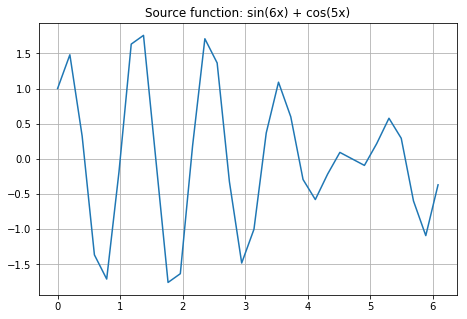

In [2]:
source_x = sp.arange(0, source_function_period, (source_function_period/N))
source_y = sp.vectorize(source_function)(source_x)


pl.figure(figsize = (15/2. , 5))
pl.title("Source function: sin(6x) + cos(5x)")
pl.plot(source_x, source_y)
pl.grid()
pl.show()

## Walsh functions

In [3]:
def reverse(m):
    r = []
    for i in range(len(m)):
        r += [[]]
        for j in range(len(m[i])):
            r[i] += [-m[i][j]]
    return r

def adamaro(n):
    if (n == 0):
        return 1
    else:
        if (n == 1):
            return [[1, 1], [1, -1]]
        else:
            p = adamaro(n-1)
            r = reverse(p)
            res = []
            for i in range(len(p)):
                res += [p[i] + p[i]]
            for i in range(len(p)):
                res += [p[i] + r[i]]
            return res

w2a = lambda x, n: sum(1<<(n-1-i) for i in range(n) if (x ^ (x>>1)) >> i&1)

ad_matrix = adamaro(log2N)

def get_walsh_adamaro(n, x):
    return ad_matrix[w2a(n, log2N)][x]

def get_walsh_walsh(n, x):
    return ad_matrix[n][x]

# print(sp.matrix(ad_matrix))

# for i in range(0,8):
#     for j in range(0,8):
#         print("W: %d; A: %d" % (get_walsh_walsh(i, j), get_walsh_adamaro(i, j)))
#     print("\n")

## Reverse walsh transformation

In [4]:
def reverse_transformation(data, n, period):
    result = []
    float_n = float(n)
    for k in range(n):
        result.append(0)
        for i in range(n):
            result[k] += data[i] * get_walsh_walsh(k, i)
    return result

## Discrete walsh transformation

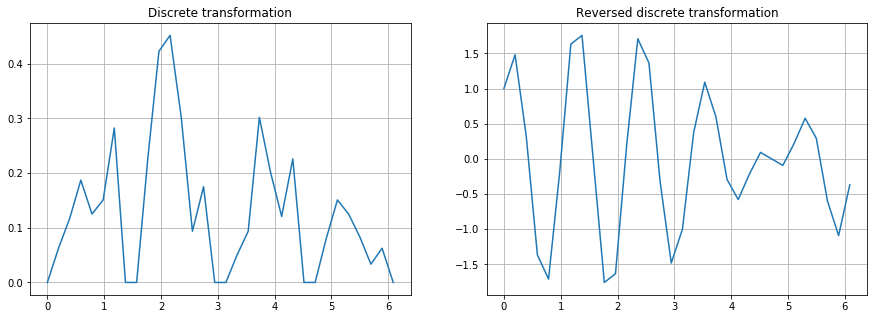

Sum: 1024, mul: 1024


In [5]:
def discrete_transformation(f, n, period):
    discrete_result = []
    sum_count = 0
    mul_count = 0
    float_n = float(n)
    for k in range(n):
        discrete_result.append(0)
        for i in range(n):
            discrete_result[k] += get_walsh_walsh(k, i) * f(period * (i/float_n))
            sum_count += 1
            mul_count += 1
        discrete_result[k] /= float_n
    return (discrete_result, sum_count, mul_count)

discrete_result, sum_count, mul_count = discrete_transformation(source_function, N, source_function_period)

discrete_y = map(lambda x: abs(x), discrete_result)
discrete_reverset_y = reverse_transformation(discrete_result, N, source_function_period)

pl.figure(figsize = (15 , 5))

pl.subplot(1, 2, 1)
pl.plot(source_x, discrete_y)
pl.title("Discrete transformation")
pl.grid()

pl.subplot(1, 2, 2)
pl.plot(source_x, discrete_reverset_y)
pl.title("Reversed discrete transformation")
pl.grid()
pl.show()

print("Sum: %d, mul: %d" % (sum_count, mul_count))

## Fast walsh transformation

C:\Users\Kimentii\Anaconda2\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


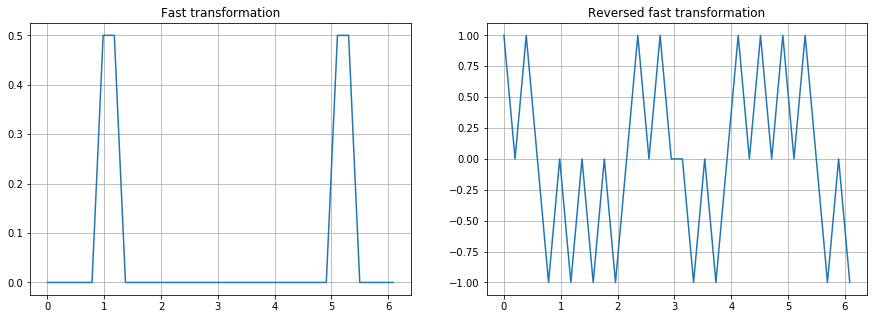

Sum: 160, mul: 80


In [6]:
def fast_transformation(f, N, period):
    source_data = []
    float_n = float(N)
    for i in range(N):
        source_data.append(complex(f(period * i/float_n)))
    result = fast_transformation_recursive(source_data, period)
    return ([x/N for x in result[0]], result[1], result[2])

def fast_transformation_recursive(data_set, period):
    n = len(data_set)
    if n == 1: 
        return (data_set, 0, 0)
    even, odd = [], []
    for i in range(n):
        if i%2 == 0:
            even.append(data_set[i])
        else:
            odd.append(data_set[i])
            
    even_result, sum_count_even, mul_count_even = fast_transformation_recursive(even, period)
    odd_result, sum_count_odd, mul_count_odd = fast_transformation_recursive(odd, period)
    sum_count = sum_count_even + sum_count_odd
    mul_count = mul_count_even + mul_count_odd
    result = [0+0j] * n
    Wn = complex(sp.cos(period / n), sp.sin(period / n))
    w = complex(1, 0)
    for i in range(n / 2):
        result[i] = even_result[i] + w * odd_result[i]
        result[i + n / 2] = even_result[i] - w * odd_result[i]
        w *= Wn
        sum_count += 2
        mul_count += 1
    return (result, sum_count, mul_count)

fast_result, sum_count, mul_count = fast_transformation(source_function, N, source_function_period)

fast_y = map(lambda x: abs(x), fast_result)
fast_reverset_y = reverse_transformation(fast_result, N, source_function_period)

pl.figure(figsize = (15 , 5))

pl.subplot(1, 2, 1)
pl.plot(source_x, fast_y)
pl.title("Fast transformation")
pl.grid()

pl.subplot(1, 2, 2)
pl.plot(source_x, fast_reverset_y)
pl.title("Reversed fast transformation")
pl.grid()
pl.show()

print("Sum: %d, mul: %d" % (sum_count, mul_count))